#### HACKDAY COMUNIDADE DS - 7 EDIÇÃO



# 0.0 Imports

In [5]:

import random
import datetime
import math

import pandas   as pd
import numpy    as np
import seaborn  as sns
import matplotlib.pyplot as plt
import lightgbm as lgb



from sklearn.linear_model    import Ridge
from sklearn.tree            import DecisionTreeRegressor
from sklearn.impute          import SimpleImputer, KNNImputer
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.preprocessing   import MaxAbsScaler
from sklearn.model_selection import train_test_split

### 0.1 Suport Functions

In [6]:
# função de transformaçao de distancia em polegadas para km
def km_para_polegadas(distancia_km):
    fator_conversao = 39370.1
    return distancia_km * fator_conversao

# calculo da metrica
def ml_error (model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame (  {'Model Name': model_name,
                            'MAE': mae,
                            'MAPE': mape,
                            'RMSE': rmse}, index=[0])


# 1.0 Descrição dos Dados

### 1.1 Load Data

In [7]:
# carregando dados

df_train = pd.read_csv ('/content/drive/MyDrive/HackDay - 7 Edição/train.csv')
df_store = pd.read_csv ('/content/drive/MyDrive/HackDay - 7 Edição/stores.csv')
df_features = pd.read_csv ('/content/drive/MyDrive/HackDay - 7 Edição/train_features.csv')

### 1.2 Data Merge

In [8]:
# merge dataframes
# merge das tabelas de 'train' e 'store'
df_feature_store = pd.merge(df_train, df_store, how='left', on='loja')

# merge das tabelas 'train e store' com 'train_features'
df_merge = pd.merge(df_feature_store, df_features, how = 'left', on=['loja', 'data'])
df_merge = df_merge.drop('feriado_y', axis = 1)
#df_merge.head(10)

### 1.3 Dtypes


In [9]:
# copia de segurança
df1 = df_merge.copy()

In [10]:
# transformando a data de 'object' para 'Datetime'
df1['data'] = pd.to_datetime('2023-' + df1['data'], format='%Y-%m-%d')

### 1.4 Fillout NaN

In [11]:
# conferindo quais colunas tem dados faltantes
df1.isna().sum()

id                             0
loja                           0
setor                          0
data                           0
vendas_semanais            12862
feriado_x                      0
tipo                           0
tamanho                    33327
temperatura                47945
combustivel                52989
desconto_1                129459
desconto_2                129510
desconto_3                129746
desconto_4                130184
desconto_5                129459
desemprego                     0
distancia_competidores    129459
clientes                       0
dtype: int64

In [12]:
# SUBSTITUINDO DADOS FALTANTES

# vendas semanais - substiuindo pela mediana com base na loja e setor
# Calcular a média do grupo e adicionar à coluna 'mean_group'
df1['mean_group'] = df1.groupby(['loja', 'setor'])['vendas_semanais'].transform('mean')

# Mesclar o DataFrame com a média do grupo
df1 = df1.merge(df1.groupby(['loja', 'setor'])['vendas_semanais'].mean().reset_index(),
                on=['loja', 'setor'],
                how='left',
                suffixes=('', '_mean'))

#substituindo os faltantes pela media
df1['vendas_semanais'] = df1['vendas_semanais'].fillna(df1['vendas_semanais_mean'])

# excluindo colunas que nao serao mais necessarias
col_drops = ['vendas_semanais_mean', 'mean_group']
df1 = df1.drop(col_drops, axis=1)
# subsiuindo os que ainda faltaram
df1['vendas_semanais'] = df1['vendas_semanais'].fillna(df1['vendas_semanais'].mean())

# tamanho - substituido por mediana
# usando KNN para estipular os valores que serao substituidos aonde nao estiver
#df1['tamanho'] = df1['tamanho'].fillna(df1['tamanho'].median())
columns = ['tamanho']
num_impute = KNNImputer(n_neighbors=5)
aux_input = df1[columns].values.reshape(-1, len(columns))
vs_inputed = num_impute.fit_transform(aux_input)
df1[columns] = vs_inputed

# temperatura - susbtituindo por média
df1['temperatura'] = df1['temperatura'].fillna(df1['temperatura'].mean())

# Combustível - substiuido pela media
df1['combustivel'] = df1['combustivel'].fillna(df1['combustivel'].median())

# descontos - substituido por zero
df1[['desconto_1', 'desconto_2', 'desconto_3', 'desconto_4', 'desconto_5']] = df1[['desconto_1', 'desconto_2', 'desconto_3', 'desconto_4', 'desconto_5']].fillna(0)

# distancia_competidores - substituindo por valor alto (200)
# convertendo polegadas em KM
df1['distancia_competidores'] = df1['distancia_competidores'].apply(km_para_polegadas)
# realizando substiuição
df1['distancia_competidores'] = df1['distancia_competidores'].apply(lambda x: 200 if math.isnan( x ) else x)



In [13]:
# conferindo se todas as colunas com dados faltantes foram substituidos
df1.isna().sum()

id                        0
loja                      0
setor                     0
data                      0
vendas_semanais           0
feriado_x                 0
tipo                      0
tamanho                   0
temperatura               0
combustivel               0
desconto_1                0
desconto_2                0
desconto_3                0
desconto_4                0
desconto_5                0
desemprego                0
distancia_competidores    0
clientes                  0
dtype: int64

### 1.5 Descrição estatistical

In [14]:
# criar dois bancos de dados separado em dados categoricos e numericos
num_atributes = df1.select_dtypes(include=['int64', 'float64'])
cat_atributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [15]:
# verificando quantas variaveis categorigas existentes
cat_atributes.apply(lambda x: x.unique().shape[0])

feriado_x    2
tipo         3
dtype: int64

# 2.0 Feauture Engineer

In [16]:
df2 = df1.copy()

In [17]:
# extraindo as datas e criando uma coluna para mes, dia e semana do ano
# mes
df2['mes'] = df1['data'].dt.month

# dia
df2['dia'] = df1['data'].dt.day

# s emana_ano
df2['semana_ano'] = df2['data'].dt.isocalendar().week
df2['semana_ano'] = df2['semana_ano'].astype('int64')


In [18]:
#  somando todos os descontos e criado uma coluna com o valor total
df2['desconto_total'] = df2[['desconto_1', 'desconto_2', 'desconto_3', 'desconto_4', 'desconto_5']].sum(axis=1)

In [19]:
# tamanho da loja com base nos quartis
df2['categoria_tamanho'] = pd.qcut(df2['tamanho'], q=[0, 0.25, 0.5, 0.75, 1], labels=['Muito Pequena', 'Pequena', 'Média', 'Grande'])

In [20]:
# renomeando a coluna 'feriado_x' para 'feriado'
df2 = df2.rename(columns={'feriado_x': 'feriado'})


In [21]:
# adicionando coluna das verdas por tipo de loja
vendas_por_tipo = df2.groupby('tipo')['vendas_semanais'].sum().reset_index()

# Renomear a coluna para evitar conflito de nomes
vendas_por_tipo = vendas_por_tipo.rename(columns={'vendas_semanais': 'soma_vendas_tipo'})

# Mesclar os resultados de volta ao DataFrame original com base na coluna 'tipo'
df2 = pd.merge(df2, vendas_por_tipo, on='tipo', how='left')


In [22]:
# adicionando coluna das verdas por setor
vendas_por_setor = df2.groupby('setor')['vendas_semanais'].sum().reset_index()

# Renomear a coluna para evitar conflito de nomes
vendas_por_setor = vendas_por_setor.rename(columns={'vendas_semanais': 'soma_vendas_setor'})

# Mesclar os resultados de volta ao DataFrame original com base na coluna 'tipo'
df2 = pd.merge(df2, vendas_por_setor, on='setor', how='left')

In [23]:
# adicionando coluna das verdas por tamanho
vendas_por_tamanho = df2.groupby('tamanho')['vendas_semanais'].sum().reset_index()

# Renomear a coluna para evitar conflito de nomes
vendas_por_tamanho = vendas_por_tamanho.rename(columns={'vendas_semanais': 'soma_vendas_tamanho'})

# Mesclar os resultados de volta ao DataFrame original com base na coluna 'tipo'
df2 = pd.merge(df2, vendas_por_tamanho, on='tamanho', how='left')

# 3.0 Filtragem de Variáveis

In [24]:
df3 = df2.copy()

In [25]:
# selecionando semanas onde teve venda entre 0 e 7000000
df3 = df3[(df3['vendas_semanais'] > 0) & (df3['vendas_semanais'] < 700000)]

In [26]:
df3.columns


Index(['id', 'loja', 'setor', 'data', 'vendas_semanais', 'feriado', 'tipo',
       'tamanho', 'temperatura', 'combustivel', 'desconto_1', 'desconto_2',
       'desconto_3', 'desconto_4', 'desconto_5', 'desemprego',
       'distancia_competidores', 'clientes', 'mes', 'dia', 'semana_ano',
       'desconto_total', 'categoria_tamanho', 'soma_vendas_tipo',
       'soma_vendas_setor', 'soma_vendas_tamanho'],
      dtype='object')

In [27]:
# excluindo colunas que nao irao agregar na predição
cols_drop = ['tamanho', 'desconto_1', 'desconto_2', 'desconto_3', 'desconto_4', 'desconto_5']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 EDA

In [28]:
df4 = df3.copy()

<ipython-input-29-e554c07499c8>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['vendas_semanais']);


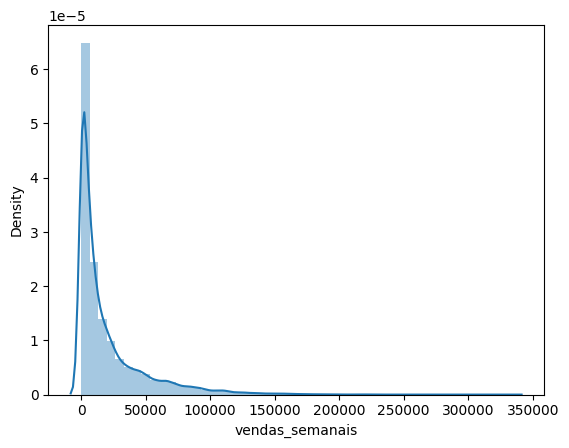

In [29]:
# verificando a distribuição da variável vendas
sns.distplot(df4['vendas_semanais']);

<Axes: xlabel='tipo', ylabel='vendas_semanais'>

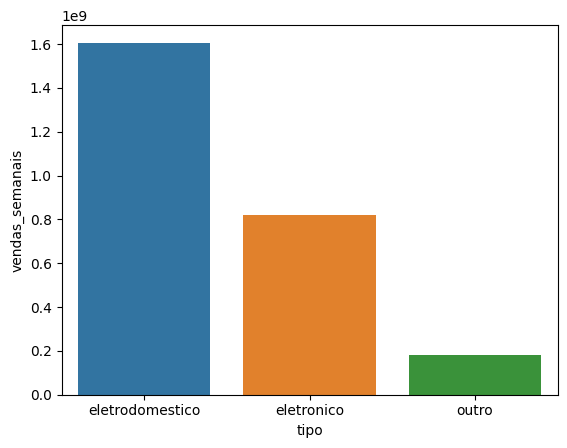

In [30]:
# analisando venda por cada tipo
venda_tipo = df4[['vendas_semanais', 'tipo']].groupby('tipo').sum().reset_index()
sns.barplot(x= 'tipo', y= 'vendas_semanais', data= venda_tipo)

<Axes: xlabel='setor', ylabel='vendas_semanais'>

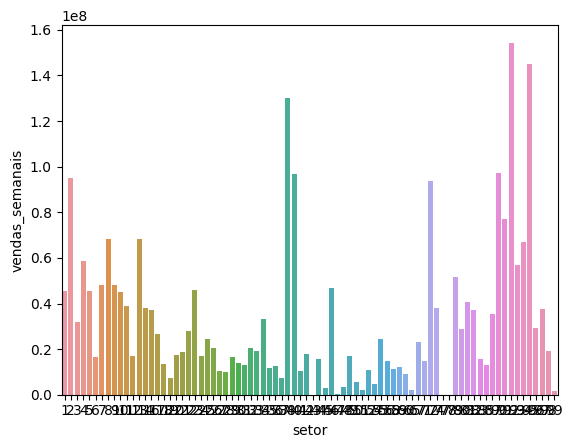

In [31]:
# analisando venda por setor
venda_tipo = df4[['vendas_semanais', 'setor']].groupby('setor').sum().reset_index()
sns.barplot(x= 'setor', y= 'vendas_semanais', data= venda_tipo)

<Axes: xlabel='categoria_tamanho', ylabel='vendas_semanais'>

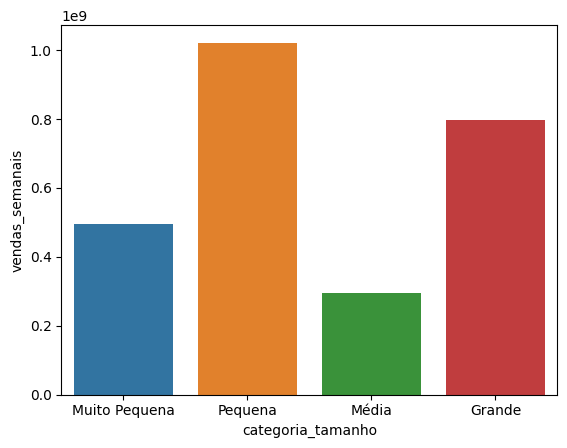

In [32]:
# analisando venda por tamanho da loja
venda_tipo = df4[['vendas_semanais', 'categoria_tamanho']].groupby('categoria_tamanho').sum().reset_index()
sns.barplot(x= 'categoria_tamanho', y= 'vendas_semanais', data= venda_tipo)

<Axes: xlabel='feriado', ylabel='vendas_semanais'>

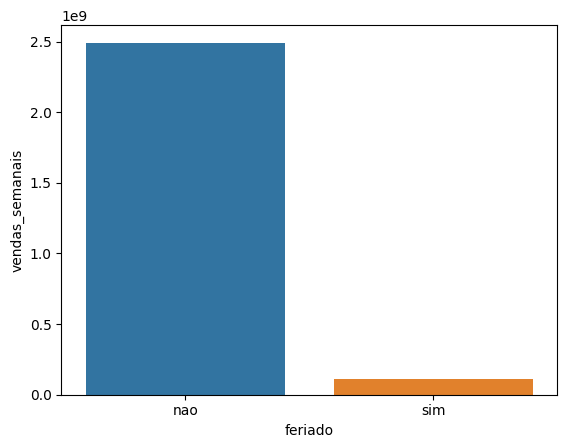

In [33]:
# analisando vendas por feriado
venda_feriado = df4[['vendas_semanais', 'feriado']].groupby('feriado').sum().reset_index()
sns.barplot(x= 'feriado', y= 'vendas_semanais', data= venda_feriado)

<ipython-input-34-b0ea3c9545a8>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot( df4[df4['feriado'] == 'sim']['vendas_semanais'], label= 'feriado', shade=True)
<ipython-input-34-b0ea3c9545a8>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot( df4[df4['feriado'] == 'nao']['vendas_semanais'], label= 'feriado', shade=True)
<ipython-input-34-b0ea3c9545a8>:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot( df4[df4['tipo'] == 'eletrodomestico']['vendas_semanais'], label= 'tipo', shade=True)
<ipython-input-34-b0ea3c9545a8>:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become a

<Axes: xlabel='vendas_semanais', ylabel='Density'>

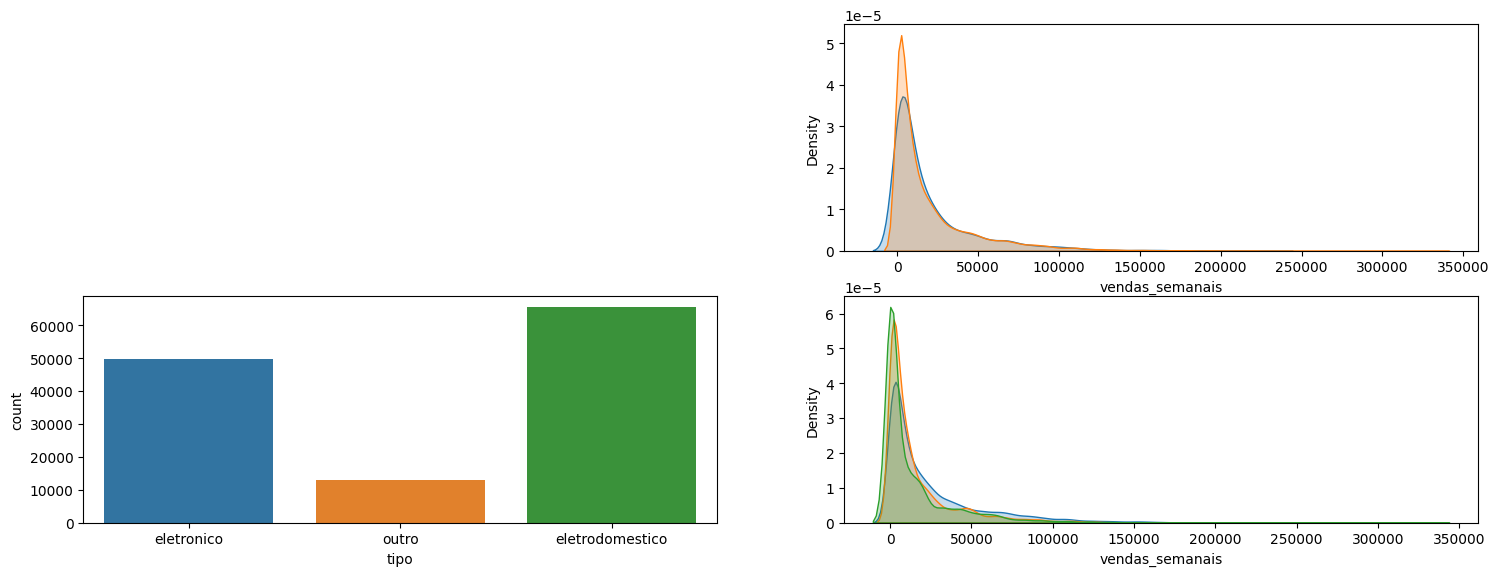

In [34]:
#separando as vendas por feriado:
plt.figure(figsize=(18,10))
plt.subplot(3, 2, 2)
sns.kdeplot( df4[df4['feriado'] == 'sim']['vendas_semanais'], label= 'feriado', shade=True)

# easter_holiday
sns.kdeplot( df4[df4['feriado'] == 'nao']['vendas_semanais'], label= 'feriado', shade=True)

# store_type
# plotando o grafico de tipo de loja
plt.subplot(3, 2, 3)
sns.countplot(x='tipo', data=df4)
# separando as vendas por cada tipo de loja e plotando o gráfico:
plt.subplot(3, 2, 4)
sns.kdeplot( df4[df4['tipo'] == 'eletrodomestico']['vendas_semanais'], label= 'tipo', shade=True)
sns.kdeplot( df4[df4['tipo'] == 'eletronico']['vendas_semanais'], label= 'eletronico', shade=True)
sns.kdeplot( df4[df4['tipo'] == 'outro']['vendas_semanais'], label= 'outro', shade=True)


<Axes: >

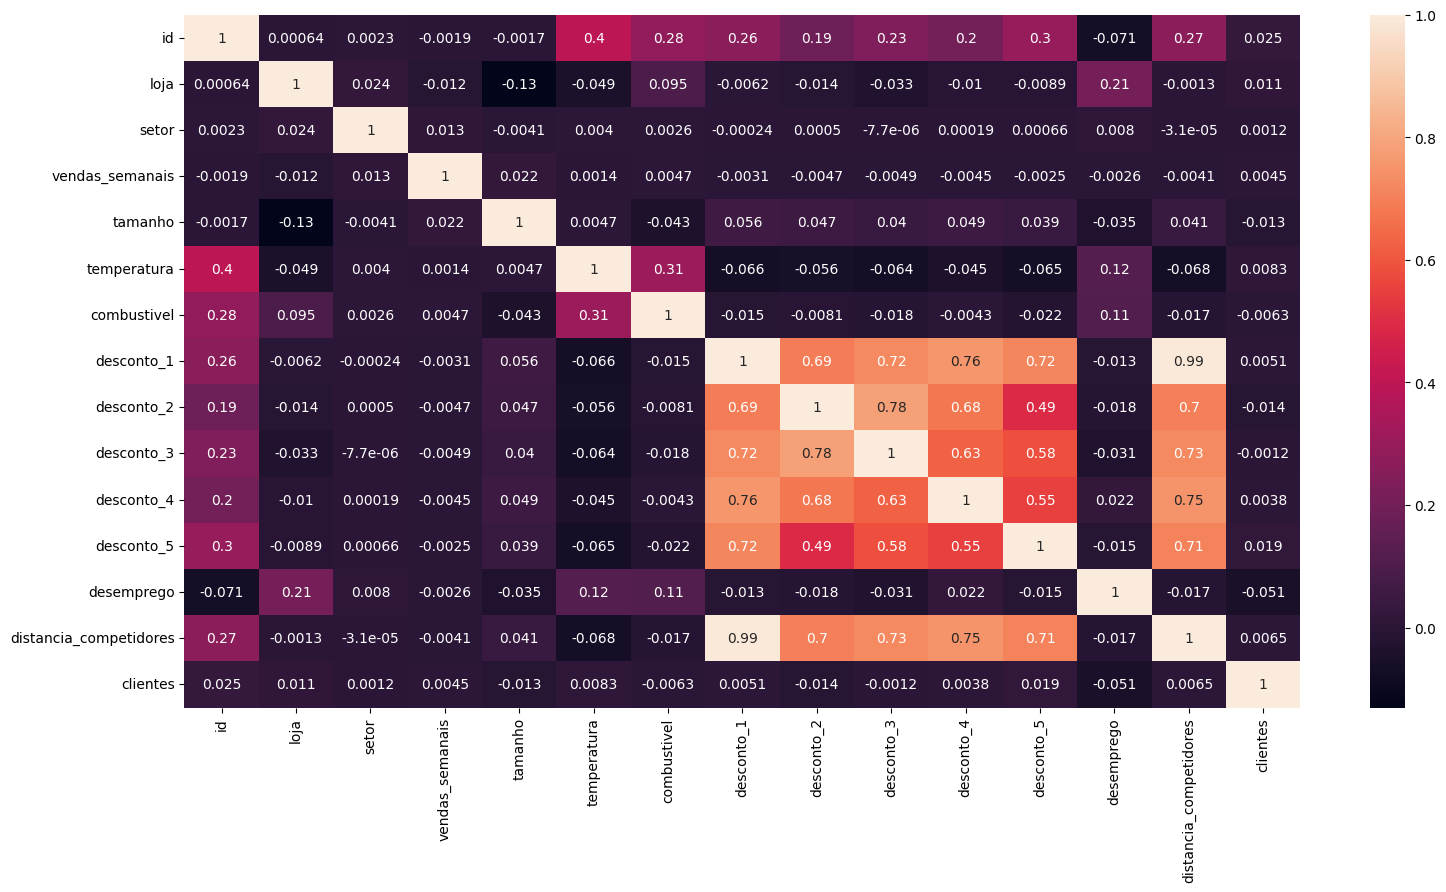

In [35]:
# correlação dos dados numericos
plt.figure(figsize =(18,9))
correlation = num_atributes.corr(method= 'pearson')
sns.heatmap(correlation, annot= True)

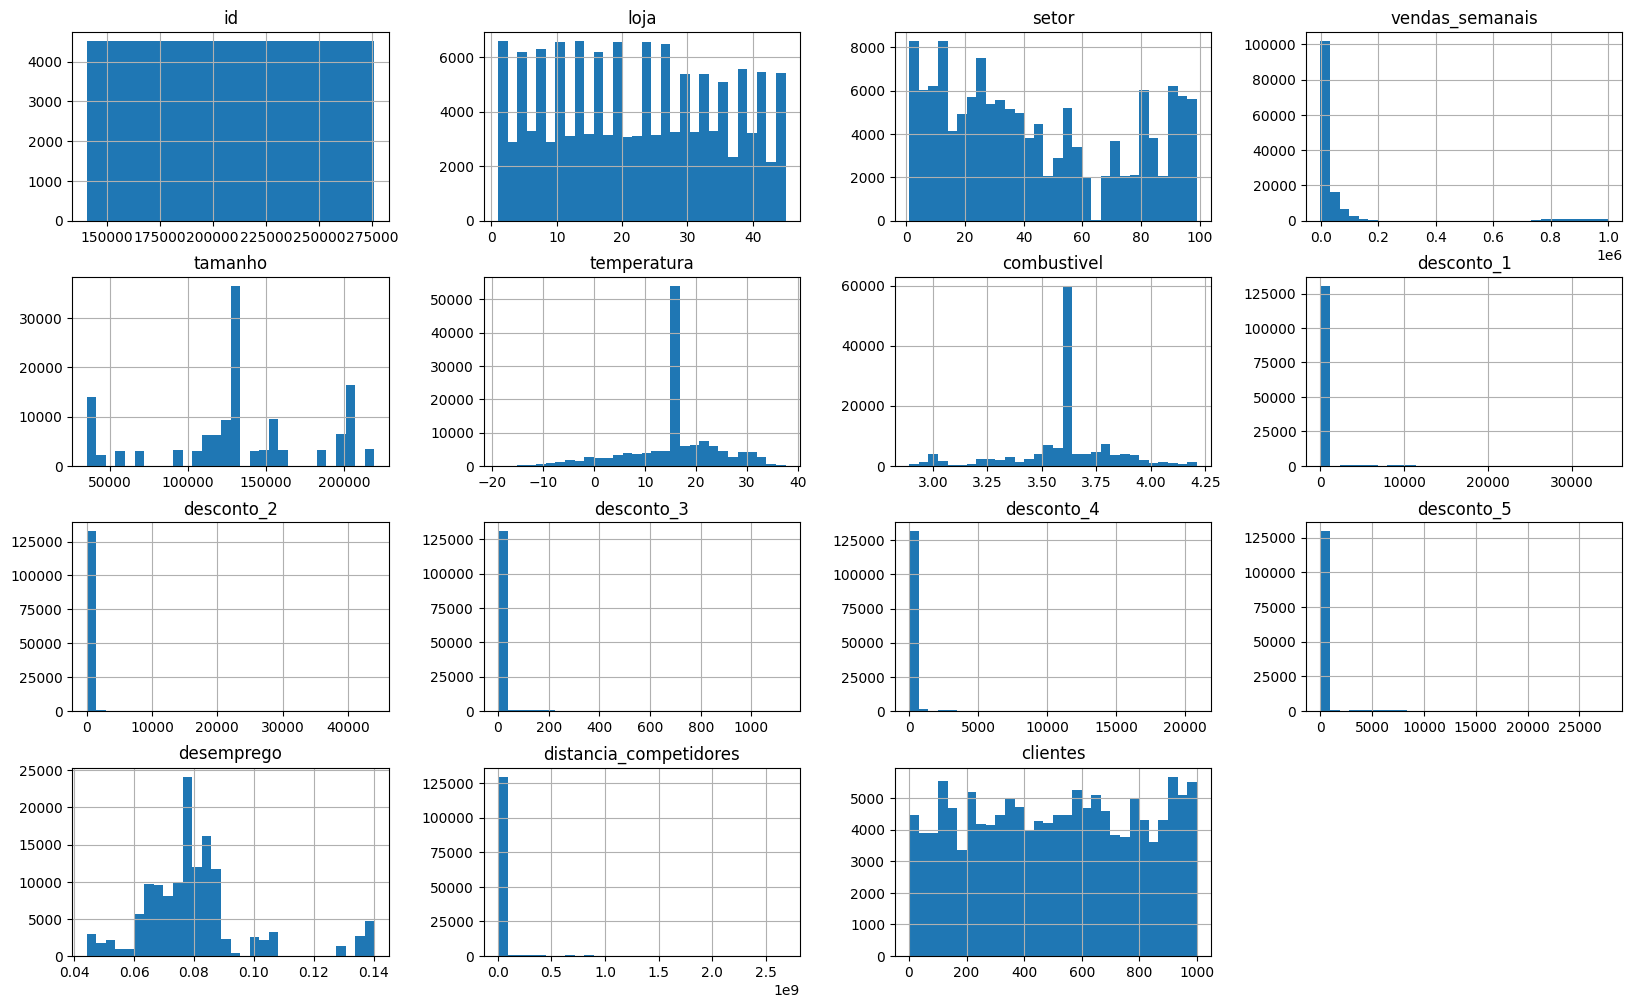

In [36]:
# histograma de todas as variaveis numericas a fim de sabver sua distribuição
num_atributes.hist(bins=30,figsize=(20, 12));

# 5.0 Preparação dos Dados

In [37]:
df5 = df3.copy()

### 5.2 Encoding

In [38]:
# store type - tecnica Label Encoder
le = LabelEncoder()
oe = OrdinalEncoder()
# tipo
df5['tipo'] = le.fit_transform(df5['tipo'])
df5['tipo'] = df5['tipo'].astype('int64')

# feriado
df5['feriado'] = le.fit_transform(df5['feriado'])

# tamanho
df5[['categoria_tamanho']] = oe.fit_transform(df5[['categoria_tamanho']]).astype('int64')

In [39]:
# trasnformação para que seja entendimo os dias como algo ciclico

# day
df5['dia_sin'] = df5['dia'].apply( lambda x: np.sin( x * ( 2. * np.pi/30) ) )
df5['dia_cos'] = df5['dia'].apply( lambda x: np.cos( x * ( 2. * np.pi/30) ) )

# month
df5['mes_sin'] = df5['mes'].apply( lambda x: np.sin( x * ( 2. * np.pi/12) ) )
df5['mes_cos'] = df5['mes'].apply( lambda x: np.cos( x * ( 2. * np.pi/12) ) )

# week of year
df5['semana_ano_sin'] = df5['semana_ano'].apply( lambda x: np.sin( x * ( 2. * np.pi/52) ) )
df5['semana_ano_cos'] = df5['semana_ano'].apply( lambda x: np.cos( x * ( 2. * np.pi/52) ) )

### 5.1 Rescaling

In [40]:
rs = RobustScaler()

df5['distancia_competidores'] = rs.fit_transform(df5[['distancia_competidores']].values)
df5['categoria_tamanho'] = rs.fit_transform(df5[['categoria_tamanho']].values)
df5['distancia_competidores'] = rs.fit_transform(df5[['distancia_competidores']].values)
df5['desemprego'] = rs.fit_transform(df5[['desemprego']].values)


In [41]:
# tranformando o target atraves do logaritmo
df5['vendas_semanais'] = np.log1p(df5['vendas_semanais'])

# 6.0 Feature Selection

In [42]:
df6 = df5.copy()

In [43]:
# definição da data de separação
df6[['loja', 'data']].groupby('loja').max().reset_index()['data'][0] - datetime.timedelta( days =5*7)

Timestamp('2023-10-14 00:00:00')

In [44]:
# do inicio da data ate 5 semanas antes sera o periodo para os dados de treino

# training dataset
X_train = df6[df6['data'] < '2023-10-14']
Y_train = X_train['vendas_semanais']

# test dataset
X_test = df6[df6['data'] >= '2023-10-14']
Y_test = X_test['vendas_semanais']

# print para conferir se as datas estao de acordo
print( f"Training Min Date: {X_train['data'].min()}")
print( f"Training Max Date: {X_train['data'].max()}")

print( f"\nTest Min Date: {X_test['data'].min()}")
print( f"Test Max Date: {X_test['data'].max()}" )

Training Min Date: 2023-01-07 00:00:00
Training Max Date: 2023-10-07 00:00:00

Test Min Date: 2023-10-14 00:00:00
Test Max Date: 2023-11-18 00:00:00


# 7.0 Modelos de Machine Learning

### 7.1 Modelos

In [45]:
df7 = df6.copy()

In [46]:
df7.columns

Index(['id', 'loja', 'setor', 'data', 'vendas_semanais', 'feriado', 'tipo',
       'temperatura', 'combustivel', 'desemprego', 'distancia_competidores',
       'clientes', 'mes', 'dia', 'semana_ano', 'desconto_total',
       'categoria_tamanho', 'soma_vendas_tipo', 'soma_vendas_setor',
       'soma_vendas_tamanho', 'dia_sin', 'dia_cos', 'mes_sin', 'mes_cos',
       'semana_ano_sin', 'semana_ano_cos'],
      dtype='object')

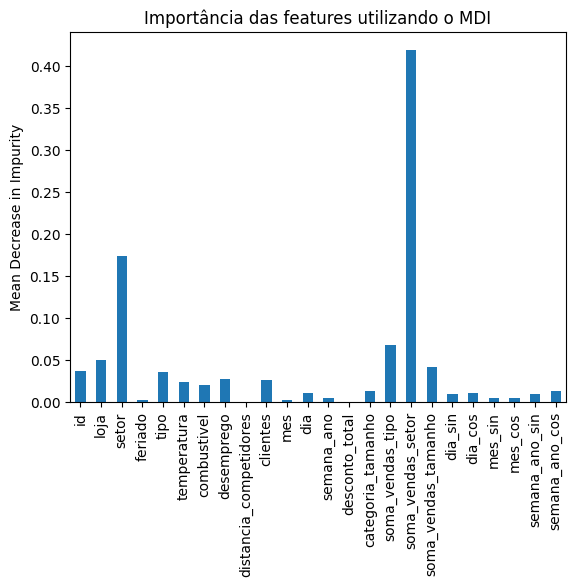

In [47]:
# Treinando um modelo de random forest para selecionar as melhores features para treinar o modelo
# training and test dataset
X_train_n = X_train.drop(['data', 'vendas_semanais'], axis=1).values
Y_train_n = Y_train.values.ravel()

# defindindo a Random Forest, nesse caso sera a Rando Forest Regressor
rf = RandomForestRegressor (n_jobs = -1)

# Pode testar mais valores de estimadores para verificar, porém a diferença na importância das features é pequena.
model_select = rf
model_select.fit(X_train_n, Y_train_n)

# Selecionando as features de maior importância através do modelo treinado
n_features = X_train_n.shape[1]
feature_names = [f"feature {i}" for i in range(n_features)]
importances = model_select.feature_importances_
forest_importances = pd.Series(importances, index = feature_names)

# MDI: calcula a redução média da impureza de cada feature e plota em um gráfico
fig, ax = plt.subplots()
forest_importances.plot.bar(ax = ax)
ax.set_title('Importância das features utilizando o MDI')
ax.set_ylabel('Mean Decrease in Impurity')
X_train_n_columns = df7.drop(['vendas_semanais', 'data'], axis = 1).columns
ax.set_xticklabels(X_train_n_columns)
plt.xticks(rotation = 90);

In [48]:
# melhores colunas selecionadas para o treinamento do modelo

cols_x = ['id',
          'loja',
          'setor',
          'vendas_semanais',
          'tipo',
          'temperatura',
          'combustivel',
          'desemprego',
          'clientes',
          'dia',
          'semana_ano',
          'categoria_tamanho',
          'soma_vendas_tipo',
          'soma_vendas_setor',
          'soma_vendas_tamanho',
          'dia_sin',
          'dia_cos',
          'mes_sin',
          'mes_cos',
          'semana_ano_sin',
          'semana_ano_cos']


In [49]:
# colunas relevantes para o modelo dividido em treino e test
xtrain = X_train[cols_x]
xtest = X_test[cols_x]

# dados para cross validation
#x_training = X_train[cols_full]

### 7.1 Random Forest

In [50]:
# modelo
rf = RandomForestRegressor(n_estimators=100, n_jobs= -1, random_state=42).fit (xtrain, Y_train)

# predição
yhat_rf = rf.predict(xtest)

# performance
rf_result = ml_error ('Random Forest', np.expm1(Y_test), np.expm1( yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest,2.36109,0.000106,71.953464


## 7.3 Linear Regression lasso

In [51]:
# model
lrr = Lasso(alpha= 0.1).fit (xtrain, Y_train)

# predicition
yhat_lrr = lrr.predict(xtest)

# performance
lrr_result = ml_error ('Linear Regression - Lasso', np.expm1(Y_test), np.expm1( yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,939.040893,0.045411,2322.923452


## 7.4 Regressão de Ridge

In [52]:
# modelo
alpha =0.1
modelo_ridge = Ridge(alpha=alpha)
modelo_ridge.fit(xtrain, Y_train)


# prediçao
predict_ridge = modelo_ridge.predict(xtest)

# performance
ridge_result = ml_error ('Ridge Regressor', np.expm1(Y_test), np.expm1( predict_ridge))
ridge_result


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.14137e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


,Model Name,MAE,MAPE,RMSE
0,Ridge Regressor,0.008778,4.048399e-07,0.022199


### 7.5 LightGBM


In [53]:
# Criar o dataset do LightGBM
train_data = lgb.Dataset(xtrain, label=Y_train)
test_data = lgb.Dataset(X_test, label=Y_test, reference=train_data)

# parametros
parametros = {
    'objective': 'regression',  # Para problemas de regressão
    'metric': 'rmse',  # Métrica de erro quadrático médio (Mean Squared Error)
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9 }

# Número de iterações
num_round = 100

# modelo
modelo = lgb.train(parametros, train_data, num_round)

# predição
yhat_lgbm = modelo.predict(xtest)

# performance
lgbm_result = ml_error ('LightGBM', np.expm1(Y_test), np.expm1( yhat_lgbm))
lgbm_result

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1813
[LightGBM] [Info] Number of data points in the train set: 111356, number of used features: 21
[LightGBM] [Info] Start training from score 8.706821


,Model Name,MAE,MAPE,RMSE
0,LightGBM,545.206782,0.033955,2347.405308


## 8.0 Resultados

In [55]:
# comparando os resultados dos algoritmos treinados a fim de escolher qual o melhor para ser implementado
comparar =pd.concat([rf_result, lrr_result, ridge_result, lgbm_result])
# ordenando do melhor resultado ao pior com base na metrica RMSE
comparar.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Ridge Regressor,0.008778,4.048399e-07,0.022199
0,Random Forest,2.361090,1.062605e-04,71.953464
0,Linear Regression - Lasso,939.040893,4.541071e-02,2322.923452
0,LightGBM,545.206782,3.395493e-02,2347.405308
